In [12]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision 
from torch import nn 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, transforms
from torch.utils.tensorboard import SummaryWriter

# Dowload data from kaggle

In [13]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# print("Path to dataset files:", path)

# Device selection


In [14]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [15]:
from torch.utils.data import random_split

# Chuan hoa
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.299, 0.224, 0.225)

#Augmentation to train
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_transform  = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Tạo dataset 
dataset = datasets.ImageFolder(root='flowers', transform=train_transforms)

# Chia cac tap
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [16]:
# Gan transform test cho val va test
val_data.dataset.transform = test_transform
test_data.dataset.transform = test_transform

# Tao dataloader 
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
# Load mô hình ResNet18 có pretrained weights
model = models.resnet18(pretrained=True)
# Freeze the layers of the pre-trained model 
# to prevent them from updating their weights during retraining.
for param in model.parameters():
    param.requires_grad = False

# Thay lớp fully connected cuối cho 5
# Replace the final classification layer of the model to match the number of classes in your dataset. 
# You can also add additional layers for customization.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5) # 5 la lop co trong dataset

#Dua model sang GPU (neu co)
model = model.to(device)
print(model.fc)

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=5, bias=True)


In [18]:
#optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [19]:
#Tensor board
writer = SummaryWriter('runs/flower_exp_1')

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch, writer):
    model.train()
    running_loss, running_correct = 0.0, 0
    size = len(dataloader.dataset)

    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        model = model.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        # Cập nhật thống kê
        running_loss += loss.item() * X.size(0)
        running_correct += (pred.argmax(1) == y).sum().item()

        # Log mỗi batch
        global_step = epoch * len(dataloader) + batch_idx
        batch_acc = 100 * (pred.argmax(1) == y).sum().item() / X.size(0)
        writer.add_scalar("Loss/train_batch", loss.item(), global_step)
        writer.add_scalar("Accuracy/train_batch", batch_acc, global_step)

    # Log epoch
    epoch_loss = running_loss / size
    epoch_acc = 100 * running_correct / size
    writer.add_scalar("Loss/train_epoch", epoch_loss, epoch)
    writer.add_scalar("Accuracy/train_epoch", epoch_acc, epoch)

    # Log histogram weights
    for name, param in model.named_parameters():
        writer.add_histogram(name, param, epoch)

    return epoch_loss, epoch_acc

In [21]:

def val_loop(dataloader, model, loss_fn, epoch, writer):
    model.eval()
    val_loss, correct = 0.0, 0
    size = len(dataloader.dataset)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            model = model.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).sum().item()

    val_loss /= size
    val_acc = 100 * correct / size

    # Log epoch
    writer.add_scalar("Loss/val_epoch", val_loss, epoch)
    writer.add_scalar("Accuracy/val_epoch", val_acc, epoch)

    return val_loss, val_acc

In [22]:
def test_loop(dataloader, model, loss_fn, epoch, writer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct

    print(f"Test error:\n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f}\n")

    # Ghi lại loss và accuracy vào TensorBoard
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/test', accuracy, epoch)

    # ✅ Thêm dòng này để trả về kết quả
    return test_loss, accuracy


In [23]:
from torch.utils.tensorboard import SummaryWriter
import torch

writer = SummaryWriter('runs/flower_classifier')

EPOCHS = 10
best_val_acc = 0.0  # lưu độ chính xác cao nhất
best_model_path = "best_flower_classifier.pth"

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-------------------------------")

    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, epoch, writer)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn, epoch, writer)

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    # 🧠 Nếu val_acc cao hơn best_val_acc, lưu lại model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ Model improved! Saved new best model with Val Acc = {val_acc:.2f}%")

    print()

writer.close()
print(f"✅ Training Complete. Best model saved at '{best_model_path}' (Val Acc = {best_val_acc:.2f}%)")


Epoch 1/10
-------------------------------
  Train Loss: 1.0477 | Train Acc: 63.26%
  Val   Loss: 0.6657 | Val   Acc: 79.51%
  ✅ Model improved! Saved new best model with Val Acc = 79.51%

Epoch 2/10
-------------------------------
  Train Loss: 0.5583 | Train Acc: 84.05%
  Val   Loss: 0.5186 | Val   Acc: 81.51%
  ✅ Model improved! Saved new best model with Val Acc = 81.51%

Epoch 3/10
-------------------------------
  Train Loss: 0.4567 | Train Acc: 86.13%
  Val   Loss: 0.4553 | Val   Acc: 84.59%
  ✅ Model improved! Saved new best model with Val Acc = 84.59%

Epoch 4/10
-------------------------------
  Train Loss: 0.3959 | Train Acc: 87.65%
  Val   Loss: 0.4297 | Val   Acc: 84.59%

Epoch 5/10
-------------------------------
  Train Loss: 0.3553 | Train Acc: 88.78%
  Val   Loss: 0.3972 | Val   Acc: 86.90%
  ✅ Model improved! Saved new best model with Val Acc = 86.90%

Epoch 6/10
-------------------------------
  Train Loss: 0.3421 | Train Acc: 88.98%
  Val   Loss: 0.3960 | Val   Acc: 

In [24]:
print("Evaluating on test set...")
test_loss, test_acc = test_loop(test_loader, model, loss_fn, EPOCHS, writer)
print(f"Final Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")

Evaluating on test set...
Test error:
 Accuracy: 87.8%, Avg loss: 0.332184

Final Test Accuracy: 87.79% | Test Loss: 0.3322


In [25]:
# Load best model
model.load_state_dict(torch.load("best_flower_classifier.pth"))
model.to(device)
print("✅ Best model loaded successfully!")

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc = test_loop(test_loader, model, loss_fn, EPOCHS, writer)
print(f"Final Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")


✅ Best model loaded successfully!
Evaluating on test set...
Test error:
 Accuracy: 87.8%, Avg loss: 0.332184

Final Test Accuracy: 87.79% | Test Loss: 0.3322


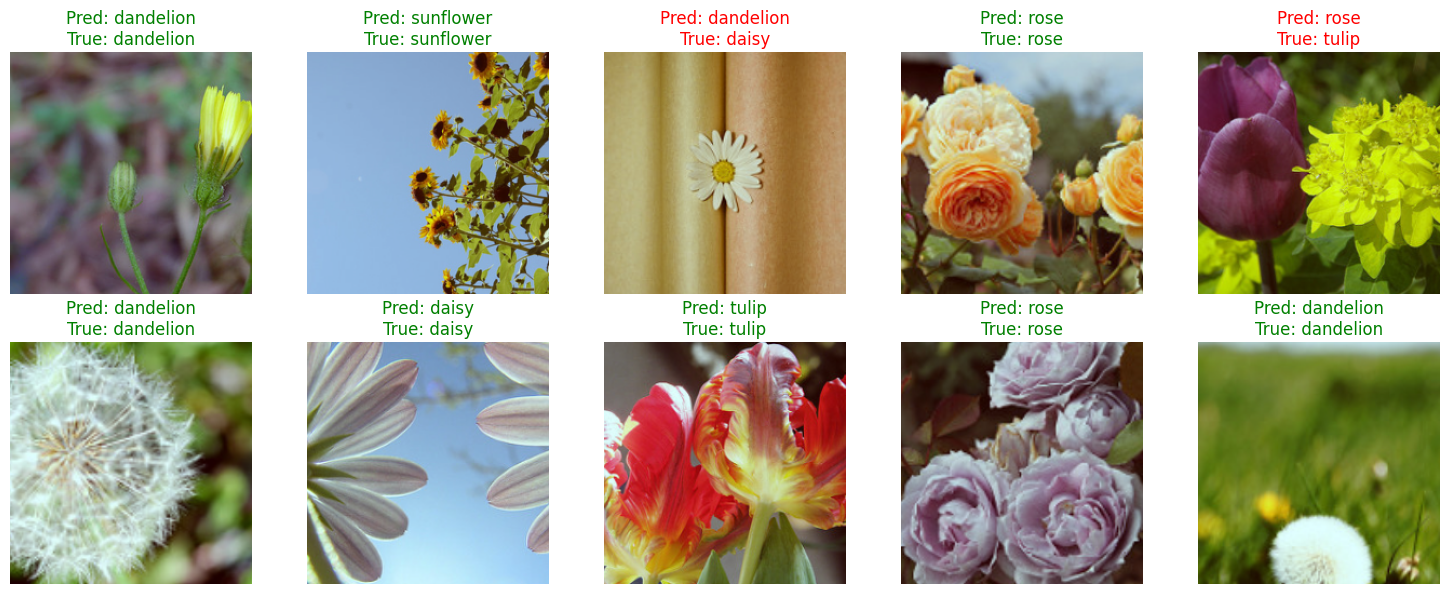

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# ===== Load dataset để lấy class names =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder('flowers/', transform=transform)
class_names = full_dataset.classes

# ===== Hàm hiển thị ảnh =====
def imshow(img, ax):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    ax.imshow(img)

# ===== Random 10 ảnh từ test dataset =====
test_dataset = test_loader.dataset  # lấy dataset gốc từ dataloader
indices = np.random.choice(len(test_dataset), size=10, replace=False)

images = []
labels = []
for idx in indices:
    img, label = test_dataset[idx]
    images.append(img)
    labels.append(label)

images = torch.stack(images).to(device)
labels = torch.tensor(labels).to(device)

# ===== Dự đoán =====
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# ===== Hiển thị ảnh và kết quả =====
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    ax = axes[i]
    imshow(images[i], ax)
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

       daisy       0.95      0.85      0.90       116
   dandelion       0.86      0.94      0.90       143
        rose       0.78      0.83      0.80        98
   sunflower       0.94      0.88      0.91       121
       tulip       0.87      0.86      0.87       169

    accuracy                           0.88       647
   macro avg       0.88      0.87      0.88       647
weighted avg       0.88      0.88      0.88       647



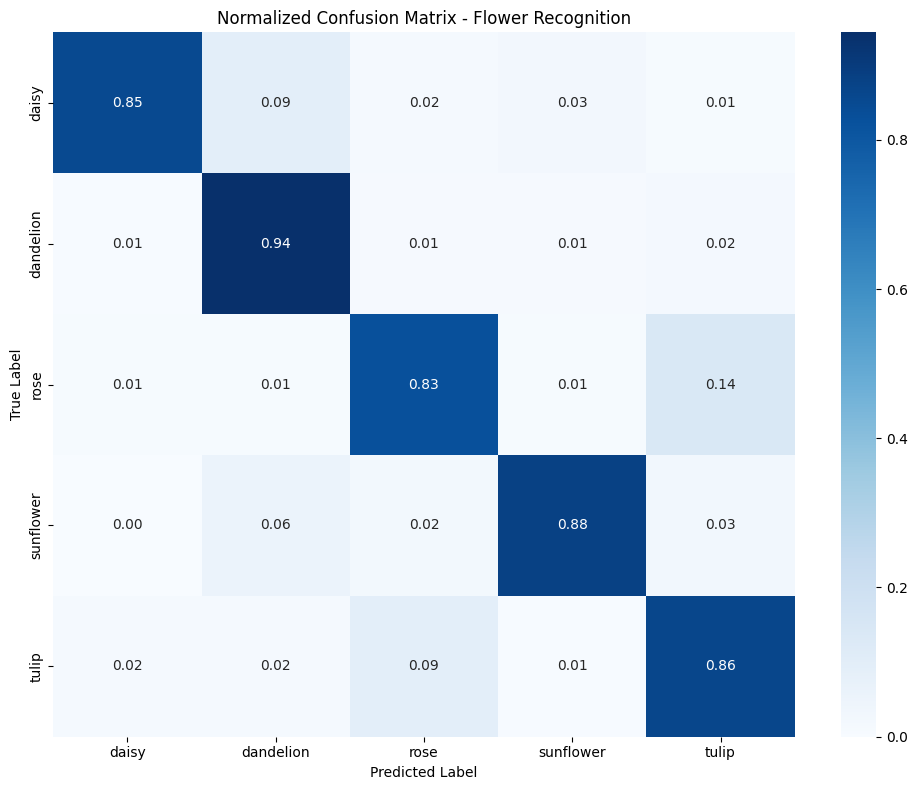

In [27]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Đưa model sang eval
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tạo confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Chuẩn hóa theo hàng

# Lấy class names
class_names = full_dataset.classes

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=class_names))


# Vẽ bằng Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix - Flower Recognition")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [36]:

%load_ext tensorboard
%tensorboard --logdir=runs/flower_classifier
# !kill 14348
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14348), started 3 days, 6:52:31 ago. (Use '!kill 14348' to kill it.)